## Installing required package

In [3]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 95.5 MB/s eta 0:00:00


## Classical Discretization

In [4]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def discretize_advection(C, dx, dt, N):
    """
    Discretize the 1D advection equation using central differences in space
    and backward Euler in time.

    Parameters:
        C (float): Advection speed
        dx (float): Spatial step size
        dt (float): Time step size
        N (int): Number of spatial points

    Returns:
        A (sparse matrix): Tridiagonal matrix representing the discretization
    """
    r = C * dt / (2 * dx)

    # Create diagonals for the tridiagonal matrix
    main_diag = np.ones(N)
    lower_diag = r * np.ones(N-1)
    upper_diag = -r * np.ones(N-1)

    # Periodic boundary conditions
    A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], shape=(N, N)).toarray()
    A[0, -1] = r  # Periodic BC
    A[-1, 0] = -r  # Periodic BC

    return A

# Example parameters
C = 1.0  # Advection speed
L = 1.0  # Domain length
N = 8    # Number of spatial points
dx = L / N
dt = 0.01  # Time step

A = discretize_advection(C, dx, dt, N)
print("Discretization matrix A:")
print(A)

Discretization matrix A:
[[ 1.   -0.04  0.    0.    0.    0.    0.    0.04]
 [ 0.04  1.   -0.04  0.    0.    0.    0.    0.  ]
 [ 0.    0.04  1.   -0.04  0.    0.    0.    0.  ]
 [ 0.    0.    0.04  1.   -0.04  0.    0.    0.  ]
 [ 0.    0.    0.    0.04  1.   -0.04  0.    0.  ]
 [ 0.    0.    0.    0.    0.04  1.   -0.04  0.  ]
 [ 0.    0.    0.    0.    0.    0.04  1.   -0.04]
 [-0.04  0.    0.    0.    0.    0.    0.04  1.  ]]


## Quantum Implementation (VQLS)

/usr/local/lib/python3.11/dist-packages/pennylane/_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/tmp/ipython-input-14-3599352136.py:93: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  classical_solution = spsolve(A, u_j)


Step 0, Cost: 0.9263849424813625
Step 10, Cost: 0.9263849424813625
Step 20, Cost: 0.9263849424813625
Step 30, Cost: 0.9263849424813625
Step 40, Cost: 0.9263849424813625
Step 50, Cost: 0.9263849424813625
Step 60, Cost: 0.9263849424813625
Step 70, Cost: 0.9263849424813625
Step 80, Cost: 0.9263849424813625
Step 90, Cost: 0.9263849424813625


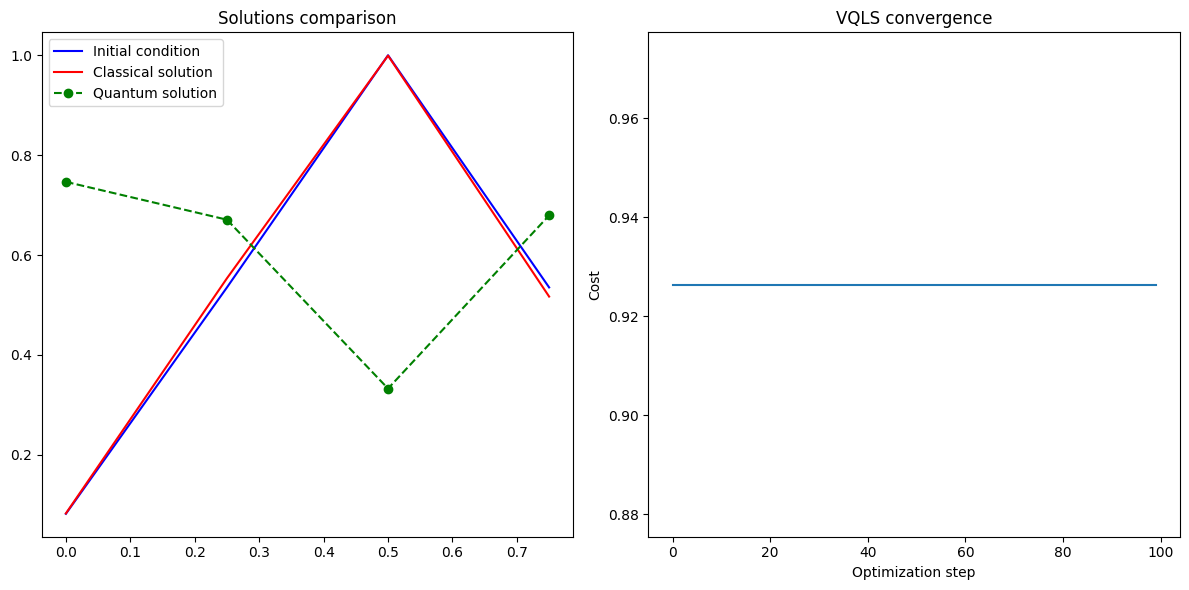

Error between quantum and classical solutions: 0.9617523492094848


In [14]:
import pennylane as qml
import numpy as onp
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

C = 1.0  # Advection speed
L = 1.0  # Domain length
N = 4    # Number of spatial points (must be power of 2 for state prep)
dx = L / N
dt = 0.01  # Time step

# Discretize
A = discretize_advection(C, dx, dt, N)

# Initial condition (Gaussian pulse)
x = onp.linspace(0, L, N, endpoint=False)
u_j = onp.exp(-(x - 0.5)**2 / 0.1)

# Normalize the initial state
norm = onp.linalg.norm(u_j)
u_j_normalized = u_j / norm

# Set up quantum device
n_qubits = int(onp.log2(N))
dev = qml.device("default.qubit", wires=n_qubits)

def ansatz(params):
    """Parameterized quantum circuit ansatz."""
    # Simple hardware-efficient ansatz
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])
    for i in range(n_qubits):
        qml.RY(params[n_qubits + i], wires=i)

def state_preparation():
    """Prepare the initial state |b⟩ = u_j."""
    # Convert normalized u_j to amplitudes
    amplitudes = u_j_normalized
    qml.MottonenStatePreparation(amplitudes, wires=range(n_qubits))

def cost_function(params):
    """Cost function for VQLS."""
    # Create the solution state |x(θ)⟩
    @qml.qnode(dev)
    def circuit():
        ansatz(params)
        return qml.probs(wires=range(n_qubits))

    # Get probabilities (squared amplitudes)
    probs = circuit()
    solution = onp.sqrt(probs) * norm  # Reconstruct solution

    # Compute cost: ||A|x⟩ - |b⟩||^2
    residual = A @ solution - u_j
    cost = onp.sum(onp.abs(residual)**2)
    return cost

def solve_with_vqls(A, u_j, steps=100):
    """Solve the linear system using VQLS."""
    # Initialize parameters
    params = onp.random.uniform(0, 2*onp.pi, size=2*n_qubits)

    # Optimizer
    opt = qml.AdamOptimizer(0.1)

    costs = []

    for i in range(steps):
        params, cost = opt.step_and_cost(cost_function, params)
        costs.append(cost)

        if i % 10 == 0:
            print(f"Step {i}, Cost: {cost}")

    # Get the final solution
    @qml.qnode(dev)
    def final_circuit():
        ansatz(params)
        return qml.probs(wires=range(n_qubits))

    probs = final_circuit()
    solution = onp.sqrt(probs) * norm

    return solution, costs

# Solve using VQLS
quantum_solution, costs = solve_with_vqls(A, u_j)

# Classical solution for comparison
classical_solution = spsolve(A, u_j)

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, u_j, 'b-', label='Initial condition')
plt.plot(x, classical_solution, 'r-', label='Classical solution')
plt.plot(x, quantum_solution, 'go--', label='Quantum solution')
plt.legend()
plt.title("Solutions comparison")

plt.subplot(1, 2, 2)
plt.plot(costs)
plt.xlabel("Optimization step")
plt.ylabel("Cost")
plt.title("VQLS convergence")

plt.tight_layout()
plt.show()

# Calculate error
error = onp.linalg.norm(quantum_solution - classical_solution)
print(f"Error between quantum and classical solutions: {error}")